In [1]:
# packages for basic python calculation
import pandas as pd
import numpy as np
import os

# warning ignore
import warnings
warnings.filterwarnings("ignore")

# packages for fft
import spectrum
from spectrum import Periodogram, data_cosine

# packages for ML
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# package for ploting
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
import seaborn as sns


# defind function for data readin
def load_data(folder_path = "../data/buy/"):
    df_gp = pd.DataFrame()
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"): 
            stock = filename[0:4]
            # print("Loading stock data:", stock, ",")
            temp_df = pd.read_csv(os.path.join(folder_path, filename), delimiter= '\s+', header = None)
            temp_df.rename(columns={123:'rtn'}, inplace=True)
            temp_df = pd.concat([pd.Series([stock] * temp_df.shape[0], name = 'stock'), temp_df], axis=1)
            df_gp = pd.concat([df_gp, temp_df], ignore_index=True)
            df_gp.reset_index()
            continue
        else:
            continue
    
    # drop rows with NA
    rows_to_drop = []
    for i in range(df_gp.shape[0]):
        if sum(df_gp.iloc[i,:].isnull()):
            rows_to_drop.append(i)
    
    df_gp = df_gp.drop(rows_to_drop, axis=0)
    #df_gp = df_gp.iloc[:,1:]   
    
    # remove duplicates
    df_gp = df_gp.drop_duplicates(subset=df_gp.columns.difference(['stock']))
    
    # change data type
    df_gp.iloc[:, 1:] = df_gp.iloc[:, 1:].astype(float)
    
    df_gp = df_gp.reset_index(drop = True)
    return df_gp

In [2]:
data_buy = load_data(folder_path= "../data/buy")
data_sell = load_data(folder_path= "../data/sell")



In [8]:
class OSC_analyzing_pipeline():
    
    """
    This class is designed and modified for the Seahorse program. It is applicable for Random Forest
    Classifier originally.
    
    Attributes:
    ----------------------------------------------------------------------------
    self.data: the input dataset that we will be using for training and testing
    self.model: the classifier we want to explore
    self.osc_gp: subset for the oscillator data
    * new addition: self.stk: subset for original stock data
    self.macd_gp: subset for the macd data
    self.rtn_gp: subset for the return values
    self.label_gp: the output for training and testing (the reponse variable)
    
    self.psd
    self.smooth
    self.first_derivitive_macd
    self.second_derivitive_macd
    self.first_derivitive_osc
    self.second_derivitive_osc
    self.partial_smooth
    
    self.feature_result_df: the feature matrix and label generated from the feature_generator function, it can be used to visual which feature is participated in model training
    self.X_train: to visual and further call the training dataset
    self.X_test: to visual and further call the test dataset
    self.y_train: to visual and further call the training dataset
    self.y_test: to visual and further call the test dataset
    
    self.report: generate the report to compare the winning rate with the original test
    The class object also contains all the attributes belongs to the model/classifier originally.
    
    Functions:
    ----------------------------------------------------------------------------
    * new addition: EDA_visualization(): function for visualization the record
    psd_calculator(): function calculate the fft values, callable with return value to be visualized
    smooth_calculator(): function for calculating the smoothness value, already modified and can handle the amplitude changes
    derivative_calculator(): function for calculating the derivitive for macd and osc
    features_generator(): function to decide which feature can be used in the final model training, the input is True/False for certain feature to be involved. In this function, all three function above will be called
    model_train(): training the model based on the feature matrix
    
    """
    
    # define the init
    def __init__(self, data):
        """
        Keyword argument:
        data -- (df) the input dataset for processing
        model -- (ML model) the classifier we are interested of, currently it is just the random forest
        """
        self.data = data
        
        # seperate indicators and returns
        # name_gp = df_gp.iloc[:, 0]
        self.osc_gp = self.data.iloc[:, 1:42]
        self.stk_gp = self.data.iloc[:, 42:83]
        self.macd_gp = self.data.iloc[:, 83:124]
        self.rtn_gp = self.data.iloc[:, 124]
        self.label_gp = np.sign(self.rtn_gp)
        self.label_gp = self.label_gp.map({1: 1, -1: 0, 0:0})
        self.results_gp = self.label_gp.map({1: 'EARN', 0: 'LOSS'})
        self.label_gp = pd.DataFrame({"label": self.label_gp})
        
    
    def EDA_visualization(self, index, osc_ind = True, stk_ind = False, macd_ind = False):
        if osc_ind:
            # plot Oscillator
            plt.figure(figsize=(12,4))
            plt.plot(range(41),  self.osc_gp.iloc[index,:])
            plt.gca().invert_xaxis()
            plt.axhline(y=0.0, color = "black",linestyle='--')
            plt.ylabel("Oscillator")
            plt.xlabel("Time")
            plt.title("Oscillator 3-Day Time Series")
            plt.show()
        

        if stk_ind:
            # plot stock price
            plt.figure(figsize=(12,4))
            plt.plot(range(41), self.stk_gp.iloc[index,:])
            plt.legend()
            plt.gca().invert_xaxis()
            plt.ylabel("Stock Price")
            plt.xlabel("Time")
            plt.title("Stock Price 3-Day Time Series")
            plt.show()
    
        if macd_ind:
        # plot MACD
            plt.figure(figsize=(12,4))
            plt.plot(range(41),  self.macd_gp.iloc[index,:])
            plt.legend()
            plt.gca().invert_xaxis()
            plt.axhline(y=0.0, color = "black",linestyle='--')
            plt.ylabel("MACD")
            plt.xlabel("Time")
            plt.title("MACD 3-Day Time Series")
            plt.show()
        
    # define function for psd calculation
    def psd_calculator(self, NFFT = 100, name = "osc"):
        """
        calculate the psd seq as new feature
        """
        freq = []
        for i in range(self.osc_gp.shape[0]):
            data_osc = self.osc_gp.iloc[i,:]
            p = Periodogram(data_osc, NFFT=NFFT)
            temp_list = list(p.psd)
            freq.append(temp_list)
        col_name = []
        for i in range(int(NFFT/2)+1):
            col_name.append("freq"+str(i))
    
        psd_df = pd.DataFrame(freq, columns=col_name)
        psd_df.index = self.osc_gp.index
        
        return psd_df
    
    # define function to calculate smoothness more directly
    def smooth_calculator(self):
        smooth_list = []
        for i in range(self.osc_gp.shape[0]):
            amp = np.mean(abs(self.osc_gp.iloc[i,:]))
            if amp == 0:
                smooth_list.append(0)
            else:
                smooth_list.append(np.var(np.diff(self.osc_gp.iloc[i,:]))/amp)
        
        smooth = pd.DataFrame(smooth_list, columns=["smooth"]) 
        smooth.index = self.osc_gp.index

        return smooth
    
    # define the function to explore the influence of partial smoothness
    def smooth_partial(self):
        # get the nearest 10 points
        osc_10 = self.osc_gp.iloc[:,-10:]
        # calculate the smoothness of 10 points
        smooth_10 = []
        for i in range(osc_10.shape[0]):
            amp = np.mean(abs(osc_10.iloc[i,:]))
            if amp == 0:
                smooth_10.append(0)
            else:
                smooth_10.append(np.var(np.diff(osc_10.iloc[i,:]))/amp)
        
        
        # get the nearest 20 points
        osc_20 = self.osc_gp.iloc[:,-20:]
        smooth_20 = []
        for i in range(osc_20.shape[0]):
            amp = np.mean(abs(osc_20.iloc[i,:]))
            if amp == 0:
                smooth_20.append(0)
            else:
                smooth_20.append(np.var(np.diff(osc_20.iloc[i,:]))/(np.mean(abs(osc_20.iloc[i,:]))))
        
        # get the nearest 30 points
        osc_30 = self.osc_gp.iloc[:,-30:]
        smooth_30 = []
        for i in range(osc_30.shape[0]):
            amp = np.mean(abs(osc_30.iloc[i,:]))
            if amp == 0:
                smooth_30.append(0)
            else:
                smooth_30.append(np.var(np.diff(osc_30.iloc[i,:]))/(np.mean(abs(osc_30.iloc[i,:]))))
        
        partial_smooth = pd.DataFrame({"smooth_10": smooth_10,
                                      "smooth_20": smooth_20,
                                      "smooth_30": smooth_30,})
        
        partial_smooth.index = self.osc_gp.index
        return partial_smooth
    
    def amp_standardize(self, osc_std = True, stk_std = True, macd_std = True):
        
        # standardize osc
        if osc_std == True:
            norm_osc = []
            mean_amp = []
    
            for i in range(self.osc_gp.shape[0]):
                mean_amp_temp = np.mean(abs(self.osc_gp.iloc[i,:]))
                mean_amp.append(mean_amp_temp)
                if mean_amp == 0: 
                    std = lambda x: x*mean_amp_temp
                    norm_osc_temp_list = list(map(std, self.osc_gp.iloc[i,:].tolist()))
                    norm_osc.append(norm_osc_temp_list)
                else:
                    std = lambda x: x/mean_amp_temp
                    norm_osc_temp_list = list(map(std, self.osc_gp.iloc[i,:].tolist()))
                    norm_osc.append(norm_osc_temp_list)
            
    
            col_name = []
            for i in range(len(norm_osc[0])):
                col_name.append("std_osc"+str(i))
            
            amp_osc = pd.DataFrame(norm_osc, columns=col_name)
            amp_osc["mean_amp_osc"] = mean_amp
            amp_osc.index = self.osc_gp.index
        
        if stk_std == True:
            norm_stk = []
            mean_amp_stk = []
            
            for i in range(self.stk_gp.shape[0]):
                mean_amp_temp = np.mean(abs(self.stk_gp.iloc[i,:]))
                mean_amp_stk.append(mean_amp_temp)
                if mean_amp_temp == 0:
                    std = lambda x: x*mean_amp_temp
                    norm_stk_temp_list = list(map(std, self.stk_gp.iloc[i,:].tolist()))
                    norm_stk.append(norm_stk_temp_list)
                else:
                    std = lambda x: x/mean_amp_temp
                    norm_stk_temp_list = list(map(std, self.stk_gp.iloc[i,:].tolist()))
                    norm_stk.append(norm_stk_temp_list)
                    
            col_name = []
            for i in range(len(norm_stk[0])):
                col_name.append("std_stk"+str(i))
            
            amp_stk = pd.DataFrame(norm_stk, columns=col_name)
            amp_stk["mean_amp_osc"] = mean_amp_stk
            amp_stk.index = self.stk_gp.index
        
        if macd_std == True:
            norm_macd = []
            mean_amp_macd = []
            
            for i in range(self.macd_gp.shape[0]):
                mean_amp_temp = np.mean(abs(self.macd_gp.iloc[i,:]))
                mean_amp_macd.append(mean_amp_temp)
                if mean_amp_temp == 0:
                    std = lambda x: x*mean_amp_temp
                    norm_macd_temp_list = list(map(std, self.macd_gp.iloc[i,:].tolist()))
                    norm_macd.append(norm_macd_temp_list)
                else:
                    std = lambda x: x/mean_amp_temp
                    norm_macd_temp_list = list(map(std, self.macd_gp.iloc[i,:].tolist()))
                    norm_macd.append(norm_macd_temp_list)
                    
            col_name = []
            for i in range(len(norm_stk[0])):
                col_name.append("std_macd"+str(i))
            
            amp_macd = pd.DataFrame(norm_macd, columns=col_name)
            amp_macd["mean_amp_osc"] = mean_amp_macd
            amp_macd.index = self.macd_gp.index
            
        return amp_osc, amp_stk, amp_macd
    
    def first_derivative_calculator(self, space = 1, name = "macd"):
        
        
        if name == "macd":
            dy = []
            for i in range(self.macd_gp.shape[0]):
                y = pd.Series(self.macd_gp.iloc[i,:])
                temp_dy = list(np.gradient(y, space))
                dy.append(temp_dy)
    
            col_name = []
            for i in range(self.macd_gp.shape[1]):
                col_name.append(name + "deriv"+ str(i))
        
            deriv_df = pd.DataFrame(dy, columns=col_name) 
            deriv_df.index = self.macd_gp.index
            
        if name == "osc":
            dy = []
            for i in range(self.osc_gp.shape[0]):
                y = pd.Series(self.osc_gp.iloc[i,:])
                temp_dy = list(np.gradient(y, space))
                dy.append(temp_dy)
    
            col_name = []
            for i in range(self.osc_gp.shape[1]):
                col_name.append(name + "deriv"+ str(i))
        
            deriv_df = pd.DataFrame(dy, columns=col_name) 
            deriv_df.index = self.osc_gp.index
            
        return deriv_df
    
    def second_derivative_calculator(self, space = 1, name = "macd"):
        
        if name == "macd":
            
            ddy = []
            for i in range(self.first_deriv_macd.shape[0]):
                y = pd.Series(self.first_deriv_macd.iloc[i,:])
                temp_ddy = list(np.gradient(y, space))
                ddy.append(temp_ddy)
    
            col_name = []
            for i in range(self.first_deriv_macd.shape[1]):
                col_name.append(name + "sec_deriv"+ str(i))
        
            sec_deriv_df = pd.DataFrame(ddy, columns=col_name) 
            sec_deriv_df.index = self.first_deriv_macd.index
        
        if name == "osc":
            
            ddy = []
            for i in range(self.first_deriv_osc.shape[0]):
                y = pd.Series(self.first_deriv_osc.iloc[i,:])
                temp_ddy = list(np.gradient(y, space))
                ddy.append(temp_ddy)
    
            col_name = []
            for i in range(self.first_deriv_osc.shape[1]):
                col_name.append(name + "sec_deriv"+ str(i))
        
            sec_deriv_df = pd.DataFrame(ddy, columns=col_name) 
            sec_deriv_df.index = self.first_deriv_osc.index
        
        
        return sec_deriv_df
    
    def var_stock_price(self):
        variance_stk = []
        for i in range(self.stk_gp.shape[0]):
            variance_stk.append(np.var(self.stk_gp.iloc[i,:]))
        
        variance = pd.DataFrame(variance_stk, columns=["stk_variance"]) 
        variance.index = self.stk_gp.index
        
        return variance
    
    def features_generator(self,
                           base_features = True,
                           psd=True, 
                           smooth=True, 
                           standardize = False, 
                           curvature=True, 
                           MACD_derivative = True, 
                           partial_smooth = True, 
                           var_stk = True):
    # Feature order:
    # 0-40, osc;
    # 41-81, stk;
    # 82-122: macd;
    # 123-173: freq
    # 174: smooth
    # 175-215: first derivitive of osc
    # 216-256: second derivitive of osc
    # 257-297: first derivitive of macd
    # 297-338: second derivitive of macd
    
    
        self.stock = pd.DataFrame(self.data.stock)
        self.stock = pd.get_dummies(self.stock)
        self.stock.index = self.data.stock.index
        
        Feature_matrix = self.data.iloc[:,1:-1]
        Feature_matrix = pd.merge(Feature_matrix, self.stock, left_index=True, right_index=True)


        
        # calculate the fft frequencies distribution for the oscillator
        if psd==True:
            print("now generating psd frequency")
            self.psd_osc = self.psd_calculator(NFFT = 100)
            Feature_matrix = pd.merge(Feature_matrix, self.psd_osc, left_index=True, right_index=True)
        
        # print(Feature_matrix)
        # Feature_matrix = pd.concat([Feature_matrix, psd_osc])
    
    # Factor for smoothness
        if smooth==True:
            print("now generating smoothness")
            self.smooth_osc = self.smooth_calculator()
            Feature_matrix = pd.merge(Feature_matrix, self.smooth_osc, left_index=True, right_index=True)
        
        if standardize == True:
            print("Normalizing the original osc, stk, macd")
            self.std_osc, self.std_stk, self.std_macd = self.amp_standardize()
            Feature_matrix = pd.merge(Feature_matrix, self.std_osc, left_index=True, right_index=True)
            Feature_matrix = pd.merge(Feature_matrix, self.std_stk, left_index=True, right_index=True)
            Feature_matrix = pd.merge(Feature_matrix, self.std_macd, left_index=True, right_index=True)
            
            
        
    # Factor for curvature
        if curvature == True:
            print("now generating osc derivitives")
        # calculate the dy for osc (way to study curvature)
            self.first_deriv_osc = self.first_derivative_calculator(name = "osc")
            Feature_matrix = pd.merge(Feature_matrix, self.first_deriv_osc, left_index=True, right_index=True)
        # calculate the ddy for osc
            self.second_deriv_osc = self.second_derivative_calculator(name = "osc")
            Feature_matrix = pd.merge(Feature_matrix, self.second_deriv_osc, left_index=True, right_index=True)
        
    # MACD dirivative
        if MACD_derivative == True:
            print("now generating MACD derivitives")
            # calculate the dy for macd
            self.first_deriv_macd = self.first_derivative_calculator(name = "macd")
            Feature_matrix = pd.merge(Feature_matrix, self.first_deriv_macd, left_index=True, right_index=True)
        # calculate the ddy for macd
            self.second_deriv_macd = self.second_derivative_calculator(name = "macd")
            Feature_matrix = pd.merge(Feature_matrix, self.second_deriv_macd, left_index=True, right_index=True)
        # Feature_matrix = pd.concat([Feature_matrix, first_deriv_macd,second_deriv_macd])
    
    # partial smoothness
        if partial_smooth == True:
            print("now generating partial smoothness")
            self.partial_smooth = self.smooth_partial()
            Feature_matrix = pd.merge(Feature_matrix, self.partial_smooth, left_index=True, right_index=True)
        
         # variance of stk
        if var_stk == True:
            print("now generating stk volatility")
            self.variance_stk = self.var_stock_price()
            Feature_matrix = pd.merge(Feature_matrix, self.variance_stk, left_index=True, right_index=True)
        
        if base_features == False:
            Feature_matrix = Feature_matrix.iloc[:,:123]
        
        self.feature_result_df = pd.merge(Feature_matrix, self.label_gp, left_index=True, right_index=True)
    
    
    def model_train(self, model_type = "RandomForest", n_estimators = 20, max_depth = 80):
        
        if model_type == "RandomForest":
            self.model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
            
        Feature_matrix = self.feature_result_df.iloc[:,:-1]
        label_gp = self.feature_result_df.iloc[:,-1]
        
        #Split test set
        self.X, self.X_test, self.y, self.y_test = train_test_split(Feature_matrix, label_gp, test_size=0.2)

        #Split train/validation set
        # self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(X, y, test_size=0.2)
        
        self.model.fit(self.X, self.y)
        
        scores = cross_val_score(self.model, self.X, self.y, cv=5)
        
        print("Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        print("Test Accuracy:", self.model.score(self.X_test, self.y_test))
        
        
        prob = self.model.predict_proba(self.X_test)
        # not quite familar and confortable with the log probability, just going to the normal probability
    
        # get the probbability of being 1
        proba_1 = []
        for probs in prob:
            proba_1.append(probs[1])
    
        df_result = pd.DataFrame({"predicted_prob":proba_1,
                             "true_label": self.y_test})
    
        df_count = df_result.groupby("predicted_prob").count()
        df_win = df_result.groupby("predicted_prob").sum()
    
        self.report = pd.DataFrame(df_win/df_count[["true_label"]])
        self.report["count"] = df_count
    
        self.report.columns = ["true_win_rate", "count"]
        
    #def feature_analyzing(self):
        

# Generating Features


In [9]:
# Build the class objective
osc_buy = OSC_analyzing_pipeline(data_buy)
osc_sell = OSC_analyzing_pipeline(data_sell)

print("For buy model")
osc_buy.features_generator()


For buy model
now generating psd frequency


KeyboardInterrupt: 

In [214]:
print("For sell model")
osc_sell.features_generator()

For sell model
now generating psd frequency
now generating smoothness
now generating osc derivitives
now generating MACD derivitives
now generating partial smoothness
now generating stk volatility


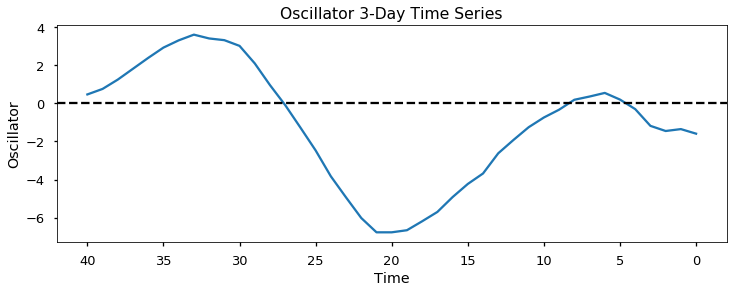

In [10]:
osc_sell.EDA_visualization(12)

In [12]:
osc_sell.

0         EARN
1         EARN
2         LOSS
3         EARN
4         EARN
5         EARN
6         EARN
7         LOSS
8         EARN
9         EARN
10        EARN
11        LOSS
12        LOSS
13        EARN
14        EARN
15        LOSS
16        LOSS
17        LOSS
18        LOSS
19        LOSS
20        LOSS
21        LOSS
22        LOSS
23        EARN
24        EARN
25        LOSS
26        EARN
27        LOSS
28        EARN
29        LOSS
          ... 
102523    LOSS
102524    LOSS
102525    LOSS
102526    EARN
102527    LOSS
102528    EARN
102529    EARN
102530    LOSS
102531    EARN
102532    LOSS
102533    LOSS
102534    EARN
102535    LOSS
102536    LOSS
102537    LOSS
102538    EARN
102539    LOSS
102540    LOSS
102541    LOSS
102542    LOSS
102543    LOSS
102544    LOSS
102545    LOSS
102546    LOSS
102547    LOSS
102548    EARN
102549    LOSS
102550    EARN
102551    EARN
102552    EARN
Name: rtn, Length: 102553, dtype: object

# EDA for different features

## Smoothness in Buy data

In [99]:

smooth_buy = osc_buy.smooth_osc["smooth"].tolist()
# smooth_buy = np.log(smooth_buy)
return_rec_buy = osc_buy.data.iloc[:,123].tolist()


df_buy_smooth = pd.DataFrame({"smooth":smooth_buy, "rtn": return_rec_buy})

Text(0,0.5,'Return')

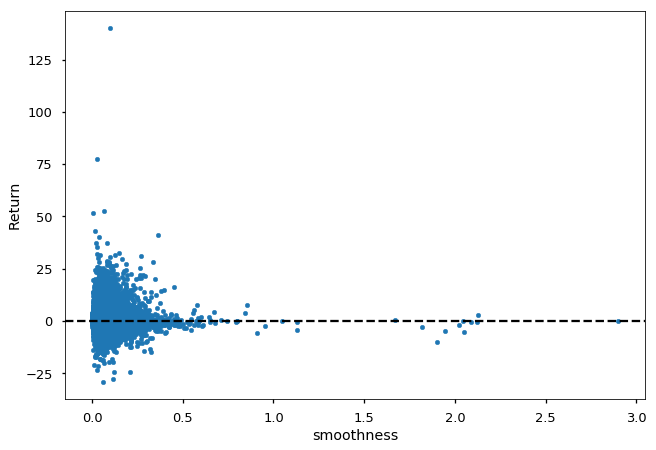

In [100]:
plt.scatter(smooth_buy, return_rec_buy, marker = ".")
plt.axhline(y = 0, color = "black", linestyle = "--")
plt.xlabel("smoothness")
plt.ylabel("Return")

Text(0,0.5,'smoothness')

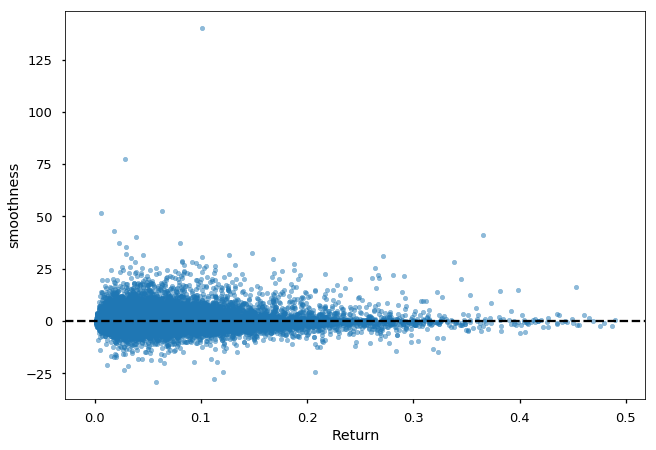

In [101]:
df_buy_smooth_zoom = df_buy_smooth[df_buy_smooth["smooth"] < 0.5]
plt.scatter(df_buy_smooth_zoom["smooth"], df_buy_smooth_zoom["rtn"], marker = ".", alpha = 0.5)
plt.axhline(y = 0, color = "black", linestyle = "--")
plt.xlabel("Return")
plt.ylabel("smoothness")

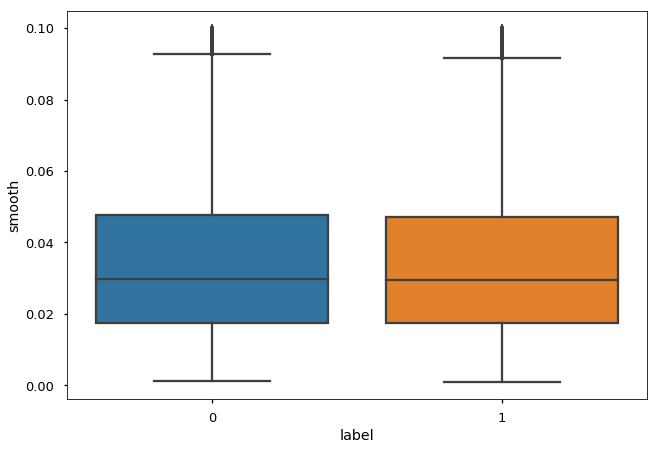

In [102]:
lable_rec_buy = osc_buy.label_gp["label"].tolist()
df_smooth_label_buy = pd.DataFrame({"label":lable_rec_buy, "smooth": smooth_buy})
df_smooth_label_buy_zoom = df_smooth_label_buy[df_smooth_label_buy["smooth"] < 0.1]
sns.boxplot(x = "label", y = "smooth", data = df_smooth_label_buy_zoom)

## Smoothness in sell data

In [103]:
smooth_sell = osc_sell.smooth_osc["smooth"].tolist()
return_rec_sell = osc_sell.data.iloc[:,123].tolist()

df_sell_smooth = pd.DataFrame({"smooth":smooth_sell, "rtn": return_rec_sell})

Text(0,0.5,'Return')

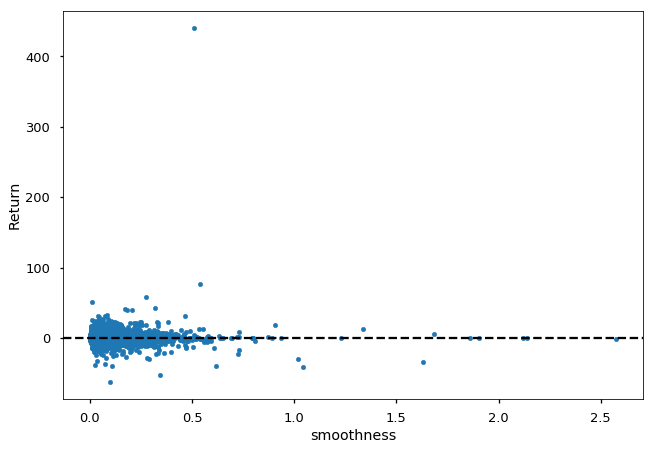

In [104]:
plt.scatter(smooth_sell, return_rec_sell, marker = ".")
plt.axhline(y = 0, color = "black", linestyle = "--")
plt.xlabel("smoothness")
plt.ylabel("Return")

Text(0,0.5,'smoothness')

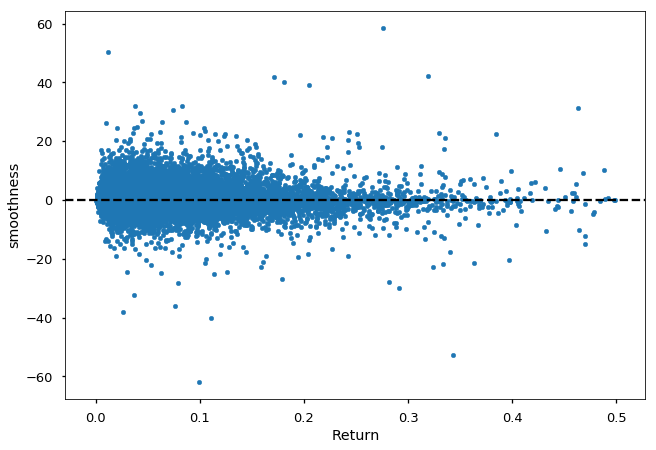

In [106]:
df_sell_smooth_zoom = df_sell_smooth[df_sell_smooth["smooth"] < 0.5]
plt.scatter(df_sell_smooth_zoom["smooth"], df_sell_smooth_zoom["rtn"], marker = ".")
plt.axhline(y = 0, color = "black", linestyle = "--")
plt.xlabel("Return")
plt.ylabel("smoothness")

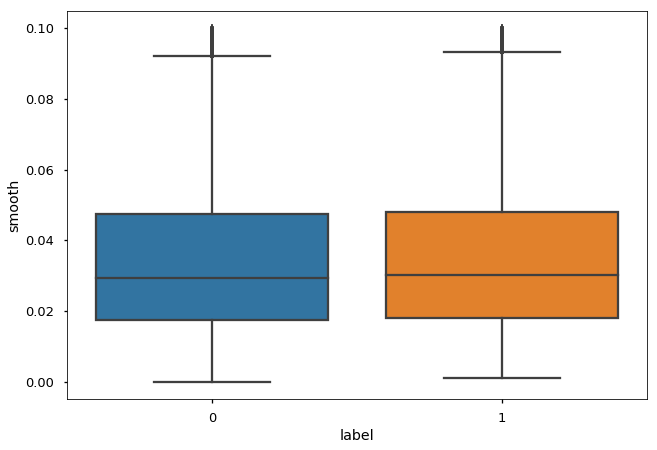

In [107]:
lable_rec_sell = osc_sell.label_gp["label"].tolist()
df_smooth_label_sell = pd.DataFrame({"label":lable_rec_sell, "smooth": smooth_sell})
df_smooth_label_sell_zoom = df_smooth_label_sell[df_smooth_label_sell["smooth"] < 0.1]
sns.boxplot(x = "label", y = "smooth", data = df_smooth_label_sell_zoom)

# Model Train: random Forest

## Buy data

In [108]:
osc_buy.model_train()

Validation Accuracy: 0.56 (+/- 0.00)
Test Accuracy: 0.5581486182989942


In [109]:
osc_buy.report.head()

,true_win_rate,count
predicted_prob,,
0.00000,0.250000,4
0.05000,0.375000,24
0.10000,0.360465,86
0.13125,0.000000,1
0.15000,0.341270,252


Text(0,0.5,'True winning probability')

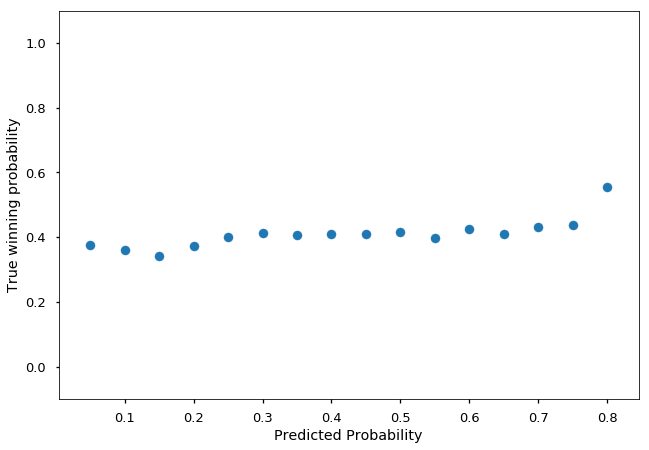

In [112]:
OSC_buy_cleaned = osc_buy.report[osc_buy.report["count"] > 5]
plt.scatter(OSC_buy_cleaned.index,OSC_buy_cleaned[["true_win_rate"]])
plt.ylim(-0.1, 1.1)
plt.xlabel("Predicted Probability")
plt.ylabel("True winning probability")

## Sell Data

In [113]:
osc_sell.model_train()
osc_buy.report.head()

Validation Accuracy: 0.57 (+/- 0.00)
Test Accuracy: 0.5706206425820292


,true_win_rate,count
predicted_prob,,
0.00000,0.250000,4
0.05000,0.375000,24
0.10000,0.360465,86
0.13125,0.000000,1
0.15000,0.341270,252


Text(0,0.5,'True winning probability')

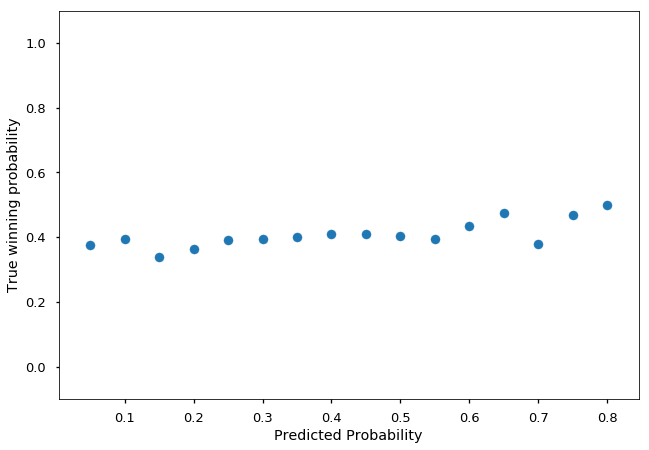

In [114]:
OSC_sell_cleaned = osc_sell.report[osc_sell.report["count"] > 5]
plt.scatter(OSC_sell_cleaned.index,OSC_sell_cleaned[["true_win_rate"]])
plt.ylim(-0.1, 1.1)
plt.xlabel("Predicted Probability")
plt.ylabel("True winning probability")

# Q1: does normalizing the amp help

Normalize the features.

In [146]:
OSC_amp_norm = OSC_analyzing_pipeline(data_buy)

In [147]:
OSC_amp_norm.features_generator(False, False, False, True, False, False,False, False)

Normalizing the original osc, stk, macd


In [148]:
OSC_amp_norm.model_train()

Validation Accuracy: 0.56 (+/- 0.01)
Test Accuracy: 0.5560003905868568


In [151]:
OSC_amp_norm.report

,true_win_rate,count
predicted_prob,,
0.000000,0.400000,10
0.050000,0.193548,31
0.100000,0.341270,126
0.104167,0.000000,1
0.150000,0.384127,315
0.180000,1.000000,1
0.200000,0.426877,759
0.204167,0.000000,1
0.216667,0.000000,2


Text(0,0.5,'True winning probability')

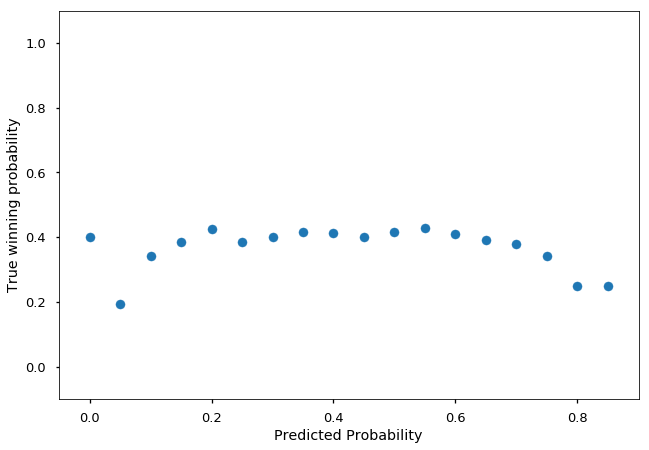

In [152]:
OSC_buy_cleaned = OSC_amp_norm.report[OSC_amp_norm.report["count"] > 6]
plt.scatter(OSC_buy_cleaned.index,OSC_buy_cleaned[["true_win_rate"]])
plt.ylim(-0.1, 1.1)
plt.xlabel("Predicted Probability")
plt.ylabel("True winning probability")

In [142]:
OSC_amp_base = OSC_analyzing_pipeline(data_buy)
OSC_amp_base.features_generator(True, False, False, False, False, False,False, False)
OSC_amp_base.model_train()
OSC_amp_base.report

Validation Accuracy: 0.56 (+/- 0.00)
Test Accuracy: 0.5602480226540377


,true_win_rate,count
predicted_prob,,
0.000000,0.111111,9
0.050000,0.242424,33
0.100000,0.364486,107
0.150000,0.378182,275
0.200000,0.388535,628
0.225000,0.000000,1
0.237500,1.000000,1
0.250000,0.409749,1313
0.300000,0.401838,2068


Text(0,0.5,'True winning probability')

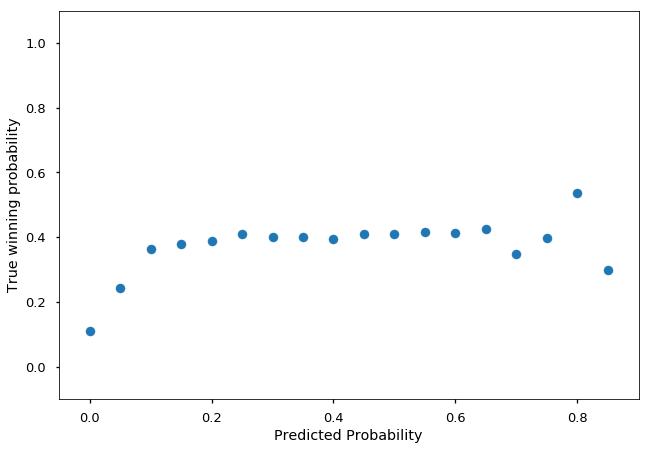

In [145]:
OSC_buy_cleaned = OSC_amp_base.report[OSC_amp_base.report["count"] > 6]
plt.scatter(OSC_buy_cleaned.index,OSC_buy_cleaned[["true_win_rate"]])
plt.ylim(-0.1, 1.1)
plt.xlabel("Predicted Probability")
plt.ylabel("True winning probability")

# Q2 Data Balance

In [183]:
from sklearn.utils import shuffle

data_buy_pos = data_buy[data_buy["rtn"] > 0]
data_buy_neg = data_buy[data_buy["rtn"] <= 0]
#print("gain len", data_buy_pos.shape[0])
#print("loss len", data_buy_neg.shape[0])

data_buy_pos_sub = data_buy_pos.sample(n = 40000)
data_buy_neg_sub = data_buy_neg.sample(n = 40000)

data_ban = data_buy_pos_sub.append(data_buy_neg_sub, ignore_index=True)
data_ban = shuffle(data_ban)
#data_combine = data_combine.reset_index(drop = True)
#data_combine

In [184]:
OSC_balance = OSC_analyzing_pipeline(data_ban)
OSC_balance.features_generator()
OSC_balance.model_train()

now generating psd frequency
now generating smoothness
now generating osc derivitives
now generating MACD derivitives
now generating partial smoothness
now generating stk volatility
Validation Accuracy: 0.51 (+/- 0.01)
Test Accuracy: 0.5053125


In [185]:
OSC_balance.report

,true_win_rate,count
predicted_prob,,
0.000000,0.000000,2
0.050000,0.500000,4
0.100000,0.500000,14
0.150000,0.333333,30
0.200000,0.401961,102
0.250000,0.410423,307
0.300000,0.502222,675
0.325000,0.000000,1
0.350000,0.491315,1209


Text(0,0.5,'True winning probability')

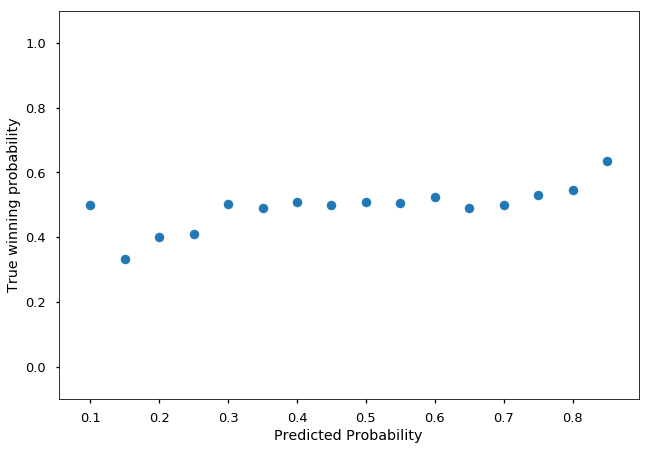

In [186]:
OSC_buy_cleaned = OSC_balance.report[OSC_balance.report["count"] > 6]
plt.scatter(OSC_buy_cleaned.index,OSC_buy_cleaned[["true_win_rate"]])
plt.ylim(-0.1, 1.1)
plt.xlabel("Predicted Probability")
plt.ylabel("True winning probability")

# Q3 Removing noise data

1. OSC_amp before signal is over 7 or below -7
2. Foe buy signal, OSC amp before signal is positive



In [195]:
data_removing_extrem = data_buy[abs(data_buy.iloc[:, 40]) < 7]
data_removing_pos = data_removing_extrem[data_removing_extrem.iloc[:,40] > 0]

In [196]:
OSC_remove_extrem = OSC_analyzing_pipeline(data_removing_pos)
OSC_remove_extrem.features_generator()
OSC_remove_extrem.model_train()

now generating psd frequency
now generating smoothness
now generating osc derivitives
now generating MACD derivitives
now generating partial smoothness
now generating stk volatility
Validation Accuracy: 0.56 (+/- 0.01)
Test Accuracy: 0.5625865137433261


In [189]:
OSC_remove_extrem.report

,true_win_rate,count
predicted_prob,,
0.000000,0.000000,3
0.050000,0.200000,15
0.100000,0.459459,37
0.150000,0.344538,119
0.200000,0.424490,245
0.250000,0.389985,659
0.300000,0.393004,972
0.333333,1.000000,1
0.350000,0.400269,1489


Text(0,0.5,'True winning probability')

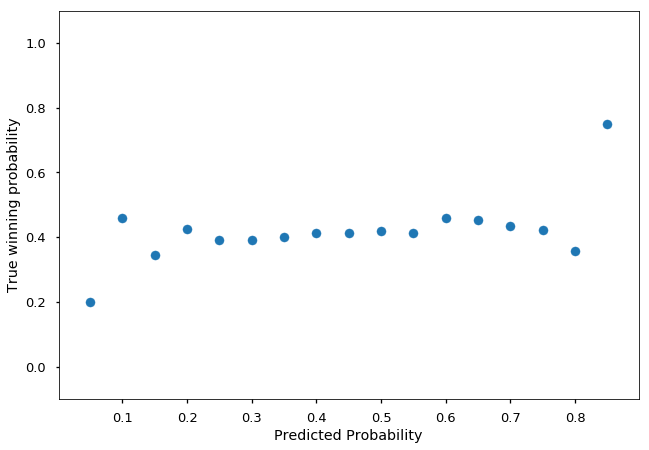

In [194]:
OSC_buy_cleaned = OSC_remove_extrem.report[OSC_remove_extrem.report["count"] > 3]
plt.scatter(OSC_buy_cleaned.index,OSC_buy_cleaned[["true_win_rate"]])
plt.ylim(-0.1, 1.1)
plt.xlabel("Predicted Probability")
plt.ylabel("True winning probability")

# Q4 introducing stk name helps?

In [224]:
OSC_name = OSC_analyzing_pipeline(data_buy)

In [225]:
OSC_name.features_generator()
OSC_name.model_train()

now generating psd frequency
now generating smoothness
now generating osc derivitives
now generating MACD derivitives
now generating partial smoothness
now generating stk volatility
Validation Accuracy: 0.56 (+/- 0.00)
Test Accuracy: 0.5588809686554047


In [227]:
OSC_name.report

,true_win_rate,count
predicted_prob,,
0.000000,0.375000,8
0.050000,0.242424,33
0.100000,0.358209,67
0.150000,0.413655,249
0.166667,0.000000,1
0.200000,0.372449,588
0.216667,0.000000,1
0.237500,0.000000,1
0.250000,0.394977,1314


Text(0,0.5,'True winning probability')

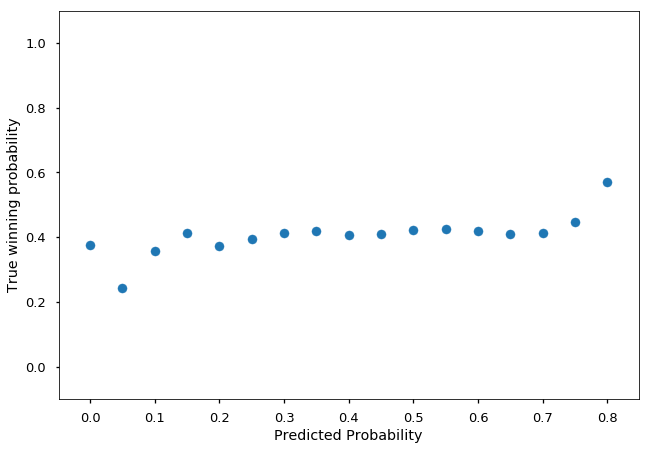

In [230]:
OSC_buy_cleaned = OSC_name.report[OSC_name.report["count"] > 6]
plt.scatter(OSC_buy_cleaned.index,OSC_buy_cleaned[["true_win_rate"]])
plt.ylim(-0.1, 1.1)
plt.xlabel("Predicted Probability")
plt.ylabel("True winning probability")


# Maybe other model?

SVM might not be applicable, since it takes enomous time to run (both train and predict)

In [237]:
#from sklearn import svm
#clf = svm.SVC(gamma='scale')
#clf.fit(OSC_name.X, OSC_name.y)  


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
#clf.score(OSC_name.X, OSC_name.y)

In [ ]:
#clf.score(OSC_name.X_test, OSC_name.y_test)